In [3227]:
using DataFrames
using Requests
using TimeSeries
using MarketTechnicals
using PyPlot

In [3228]:
function getcsv(url)
    # without error checking
    df = readtable(Requests.get_streaming(url))
end
function yahoo(url)
    df = getcsv(url)
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    dataarray=convert(Array, df[1:end,[2,3,4,7,6]])
    ta=TimeArray(timestamp,dataarray,colnames[2:end-1])
end
function quandl(url)
    df = getcsv(url)
    timestamp = Date[Date(i) for i in df[1]] # parse dates
    colnames=AbstractString[string(i) for i in DataFrames.names(df)]
    dataarray=convert(Array, df[2:end])
    ta=TimeArray(timestamp,dataarray,colnames[2:end])
end

quandl (generic function with 1 method)

In [3229]:
qqq="http://real-chart.finance.yahoo.com/table.csv?s=QQQ&a=00&b=1&c=2011g=d&ignore=.csv"
spy="http://real-chart.finance.yahoo.com/table.csv?s=SPY&a=00&b=1&c=2011g=d&ignore=.csv"
uso="http://real-chart.finance.yahoo.com/table.csv?s=USO&a=00&b=1&c=2011g=d&ignore=.csv"
gld="http://real-chart.finance.yahoo.com/table.csv?s=GLD&a=00&b=1&c=2011g=d&ignore=.csv"
uup="http://real-chart.finance.yahoo.com/table.csv?s=UUP&a=00&b=1&c=2011g=d&ignore=.csv"
euo="http://real-chart.finance.yahoo.com/table.csv?s=EUO&a=00&b=1&c=2011g=d&ignore=.csv"
ashr="http://real-chart.finance.yahoo.com/table.csv?s=ASHR&a=00&b=1&c=2011g=d&ignore=.csv"
ohlcv=yahoo(qqq)

4318x5 TimeSeries.TimeArray{Real,2,DataType} 1999-03-10 to 2016-05-05

             Open      High      Low       Close     Volume          
1999-03-10 | 102.25    102.3125  100.5625  46.233    5232000         
1999-03-11 | 102.875   103.4688  100.625   46.4593   9688600         
1999-03-12 | 102.25    102.3125  99.3125   45.3275   8743600         
1999-03-15 | 100.875   103.125   99.8125   46.6291   6369000         
⋮
2016-05-02 | 105.99    106.87    105.55    106.72    24791000        
2016-05-03 | 105.96    106.44    105.45    105.73    36351400        
2016-05-04 | 105.12    105.48    104.79    105.05    26689000        
2016-05-05 | 105.43    105.66    104.81    105.02    20724800        


In [3230]:
ta=ohlcv["Close"];
splitoffset=252-24;
vix=quandl("https://www.quandl.com/api/v3/datasets/CBOE/VIX.csv?api_key=VKyXNok9WfyAwAHtZBCR&start_date=2011-01-01")
vixarray=TimeArray(vix.timestamp,vix.values[:,end],[vix.colnames[end]])

1344x1 TimeSeries.TimeArray{Float64,1,DataType} 2011-01-03 to 2016-05-05

             VIX_Close  
2011-01-03 | 17.61      
2011-01-04 | 17.38      
2011-01-05 | 17.02      
2011-01-06 | 17.4       
⋮
2016-05-02 | 14.68      
2016-05-03 | 15.6       
2016-05-04 | 16.05      
2016-05-05 | 15.91      


In [3231]:
function averagetruerange(ohlc, n=14, h="High", l="Low", c="Close")
    highs = merge(ohlc[h], lag(ohlc[c]))
    lows = merge(ohlc[l], lag(ohlc[c]))
    hi=convert(Array{Real,1},[maximum(highs.values[i,:]) for i=1:size(highs.values)[1]])
    lo=convert(Array{Real,1},[minimum(lows.values[i,:]) for i=1:size(lows.values)[1]])
    truehigh = TimeArray(highs.timestamp, hi, ["hi"], highs.meta)
    truelow  = TimeArray(lows.timestamp, lo, ["lo"], lows.meta)
    res = ema(truehigh .- truelow, n, wilder=true)
    TimeArray(res.timestamp, res.values, ["atr"], ohlc.meta)
end

averagetruerange (generic function with 5 methods)

In [3232]:
function macd2(ta, fast=12, slow=26, signal=9)
    mcd = ema(ta, fast) .- ema(ta, slow)
    sig = ema(mcd, signal)
    merge(mcd, sig, col_names=["macd", "signal"])
end

macd2 (generic function with 4 methods)

In [3233]:
function moneyflowindex(ohlcv, n=14, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    typical=(hi.+lo.+cl)./3
    diff=typical.-lag(typical)
    positive=convert(Array{Real,1},[i[2][1]>0?i[2][1]:0 for i in diff])
    negative=convert(Array{Real,1},[i[2][1]<0?abs(i[2][1]):0 for i in diff])
    pflow=TimeArray(diff.timestamp,positive,["Positive"]).*volume
    nflow=TimeArray(diff.timestamp,negative,["Negative"]).*volume
    psum=moving(pflow,sum,n)
    nsum=moving(nflow,sum,n)
    flowsum=psum.+nsum
    re=psum./flowsum
    TimeArray(re.timestamp, re.values, ["mfi"], ohlcv.meta)
end

moneyflowindex (generic function with 6 methods)

In [3234]:
function chaikinmoneyflow(ohlcv, n=20, h="High", l="Low", c="Close", v="Volume")
    hi=ohlcv[h]
    lo=ohlcv[l]
    cl=ohlcv[c]
    volume=ohlcv[v]
    moneyflowvolume = ((cl.-lo).-(hi.-cl))./(hi.-lo).*volume
    moneyflowsum=moving(moneyflowvolume,sum,n)
    volumesum=moving(volume,sum,n)
    re=moneyflowsum./volumesum
    TimeArray(re.timestamp, re.values, ["cmf"], ohlcv.meta)
end

chaikinmoneyflow (generic function with 6 methods)

In [3235]:
function overlaps(t1::Vector, t2::Vector)
    i = j = 1
    idx1 = Int[]
    idx2 = Int[]
    while i <= length(t1) && j <= length(t2)
        if t1[i] > t2[j]
            j += 1
        elseif t1[i] < t2[j]
            i += 1
        else
            push!(idx1, i)
            push!(idx2, j)
            i += 1
            j += 1
        end
    end
    (idx1, idx2)        
end

overlaps (generic function with 1 method)

In [3236]:
function mergetimearray(ta1, ta2)
    idx1, idx2 = overlaps(ta1.timestamp, ta2.timestamp)
    vals = [ta1[idx1].values ta2[idx2].values]
    TimeArray(ta1[idx1].timestamp, vals, [ta1.colnames; ta2.colnames])
end

mergetimearray (generic function with 1 method)

In [3237]:
function pricerangeindex(ta, n=26)
    high=moving(ta, maximum, n)
    low=moving(ta, minimum, n)
    lh=merge(low, high, col_names = ["min", "max"])
    lh2=lh
    for i=1:n-1
        lh2=lead(lh2)
    end
    ranges=mergetimearray(ta,lh2)
    index=[Real((i[2][1]-i[2][2])/(i[2][3]-i[2][2])) for i in ranges]
    TimeArray(ranges.timestamp, [ranges.values index], [ranges.colnames;["pricerange"]])
end

pricerangeindex (generic function with 2 methods)

In [3238]:
function bollingerbands2{T,N}(ta::TimeArray{T,N}, ma::Int, width::Real)
    tama   = sma(ta, ma)
    upband = tama .+ moving(ta, std, ma) .* width .* sqrt((ma-1)/ma) # take out Bessel correction, per algorithm
    dnband = tama .- moving(ta, std, ma) .* width .* sqrt((ma-1)/ma)
    bands  =  merge(upband, dnband) 
    merge(bands, tama, col_names = ["up", "down", "mean"])
end

bollingerbands2 (generic function with 1 method)

In [3239]:
function bollingerbands_deviation(ta, n=20, width=2)
    bbands=bollingerbands2(ta,n,width)
    bbprice=mergetimearray(bbands,ta)
    bbstd=(bbands.values[:,1].-bbands.values[:,3])./2
    bbdev=(bbprice.values[:,4].-bbands.values[:,3])./(bbands.values[:,1].-bbands.values[:,3])
    TimeArray(bbands.timestamp, [bbdev bbstd], ["bbdev", "bbstd"])
end

bollingerbands_deviation (generic function with 3 methods)

In [3240]:
function moneyflow_deviation(rsi, mfi)
    rm=mergetimearray(rsi,mfi)
    mfdev=TimeArray(rm.timestamp,rm.values[:,2]-rm.values[:,1],["moneyflowdev"])
    mfdevema=ema(mfdev,6)
    TimeArray(mfdevema.timestamp,mfdevema.values,["mfidev"])
end

moneyflow_deviation (generic function with 1 method)

In [3241]:
rsiarray=rsi(ta)./100;
rsi26array=rsi(ta,26)./100;

In [3242]:
atrarray=averagetruerange(ohlcv);
atr26array=averagetruerange(ohlcv,26);

In [3243]:
mfiarray=moneyflowindex(ohlcv);
mfi26array=moneyflowindex(ohlcv,26);

In [3244]:
macdarray=macd2(ta);
cmfarray=chaikinmoneyflow(ohlcv);
bbarray=bollingerbands_deviation(ta);
mfidevarray=moneyflow_deviation(rsiarray, mfiarray)
rangeindexarray=pricerangeindex(ta);

In [3245]:
featurearray=mergetimearray(atrarray,rsiarray);

In [3246]:
featurearray=mergetimearray(featurearray,mfiarray);

In [3247]:
featurearray=mergetimearray(featurearray,mfidevarray);

In [3248]:
featurearray=mergetimearray(featurearray,cmfarray);

In [3249]:
featurearray=mergetimearray(featurearray,bbarray);

In [3250]:
featurearray=mergetimearray(featurearray,macdarray);

In [3251]:
featurearray=mergetimearray(featurearray,atr26array);
featurearray=mergetimearray(featurearray,rsi26array);
featurearray=mergetimearray(featurearray,mfi26array);

In [3252]:
featurearray=mergetimearray(featurearray,vixarray);

In [3253]:
featurearray1=mergetimearray(featurearray,rangeindexarray);

In [3254]:
featurearray2=mergetimearray(featurearray,ta);

In [3255]:
splitdate=featurearray1.timestamp[end]

2016-03-31

In [3256]:
sidx=searchsortedfirst(featurearray2.timestamp, splitdate)-splitoffset

1091

In [3257]:
oldfeatures=TimeArray(featurearray1.timestamp[1:sidx],featurearray1.values[1:sidx,:],featurearray1.colnames)

1091x17 TimeSeries.TimeArray{Real,2,DataType} 2011-01-03 to 2015-05-05

             atr     rsi     mfi     mfidev  cmf      bbdev   bbstd   macd    signal  atr     rsi     mfi     VIX_Close  Close     min       max       pricerange  
2011-01-03 | 3.5802  0.7204  0.7762  0.0539  -16.3062 1.0738  0.3731  0.491   0.5293  3.5648  0.681   0.7108  17.61      52.0058   51.9682   54.5633   0.0145      
2011-01-04 | 3.5776  0.7034  0.7682  0.057   -15.685  0.9224  0.3751  0.5013  0.5237  3.564   0.6728  0.7101  17.38      51.9682   51.9682   54.5633   0.0         
2011-01-05 | 3.5929  0.7752  0.8329  0.0572  -15.6982 1.2598  0.4133  0.5389  0.5267  3.5728  0.7163  0.7713  17.02      52.4102   52.3537   54.5633   0.0255      
2011-01-06 | 3.5898  0.797   0.8401  0.0532  -16.1776 1.2025  0.4653  0.5757  0.5365  3.5719  0.7311  0.8754  17.4       52.5794   52.3537   54.9489   0.087       
⋮
2015-04-30 | 1.8734  0.4193  0.4302  -0.0387 -2.1645  -0.0575 1.4544  0.7197  0.6361  1.9078  0.4871  0.39

In [3258]:
newfeatures=TimeArray(featurearray2.timestamp[sidx+1:end],featurearray2.values[sidx+1:end,:],featurearray2.colnames)

253x14 TimeSeries.TimeArray{Real,2,DataType} 2015-05-06 to 2016-05-05

             atr     rsi     mfi     mfidev  cmf     bbdev   bbstd   macd    signal  atr     rsi     mfi     VIX_Close  Close     
2015-05-06 | 1.9139  0.3686  0.3662  -0.0275 -2.1615 -0.6441 1.1781  0.3544  0.5786  1.9272  0.4416  0.4011  15.15      105.5702  
2015-05-07 | 1.9257  0.431   0.4455  -0.0155 -2.182  -0.3767 1.1766  0.2555  0.514   1.9331  0.4743  0.4239  15.13      106.2034  
2015-05-08 | 1.9822  0.5406  0.4658  -0.0325 -2.2522 0.1672  1.1746  0.2809  0.4674  1.9632  0.5358  0.4917  12.86      107.5291  
2015-05-11 | 1.9443  0.5054  0.4361  -0.043  -2.2772 -0.0267 1.1601  0.2645  0.4268  1.9435  0.5154  0.4874  13.85      107.1135  
⋮
2016-05-02 | 1.4428  0.3376  0.2222  -0.0374 0.0741  -0.777  1.5956  -0.1945 0.4623  1.5309  0.4109  0.3822  14.68      106.72    
2016-05-03 | 1.4305  0.2792  0.0825  -0.0829 0.0654  -0.9378 1.7658  -0.3702 0.2958  1.5209  0.3699  0.3636  15.6       105.73    
2016-05-04

In [3259]:
closeidx=findfirst(oldfeatures.colnames,"Close")

14

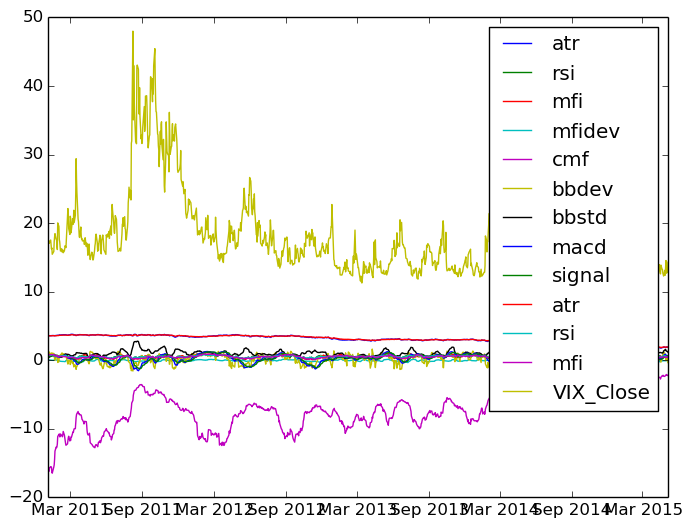

MethodError: MethodError: no method matching writemime(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
Closest candidates are:
  writemime(::IO, ::MIME{symbol("image/svg+xml")}, ::PyCall.PyObject)
  writemime(::IO, !Matched::AbstractString, ::Any)
  writemime(::IO, !Matched::MIME{symbol("text/csv")}, ::Any)
  ...

In [3260]:
plot(oldfeatures.timestamp,oldfeatures.values[:,1:closeidx-1])
legend(oldfeatures.colnames[1:closeidx-1])

In [3261]:
using DecisionTree
using ScikitLearn

In [3262]:
ntrees=500
pricerangeidx=closeidx+3
features=oldfeatures.values[:,1:closeidx]
labels=convert(Array{Float64,1},oldfeatures.values[:,pricerangeidx])
model = build_forest(labels,features, 2, ntrees, 5, 0.7)

Ensemble of Decision Trees
Trees:      500
Avg Leaves: 259.342
Avg Depth:  20.246

In [3263]:
newlabels=apply_forest(model, newfeatures.values);

In [3264]:
initvalue=oldfeatures.values[1,closeidx]

52.005841

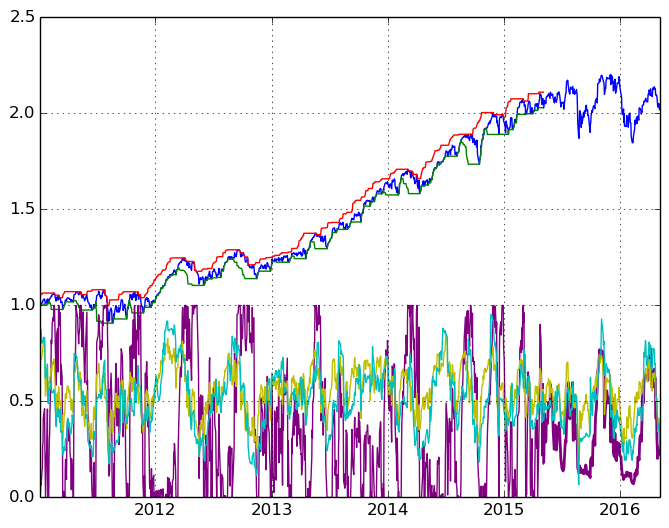

In [3265]:
plot(oldfeatures.timestamp,oldfeatures.values[:,closeidx:pricerangeidx-1]./initvalue)
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue,c="b")
plot(oldfeatures.timestamp,labels,c="Purple")
plot(newfeatures.timestamp,newlabels,c="Purple",linewidth=2)
plot(oldfeatures.timestamp,oldfeatures.values[:,11],c="y")
plot(newfeatures.timestamp,newfeatures.values[:,11],c="y")
plot(oldfeatures.timestamp,oldfeatures.values[:,12],c="c")
plot(newfeatures.timestamp,newfeatures.values[:,12],c="c")
grid("on")

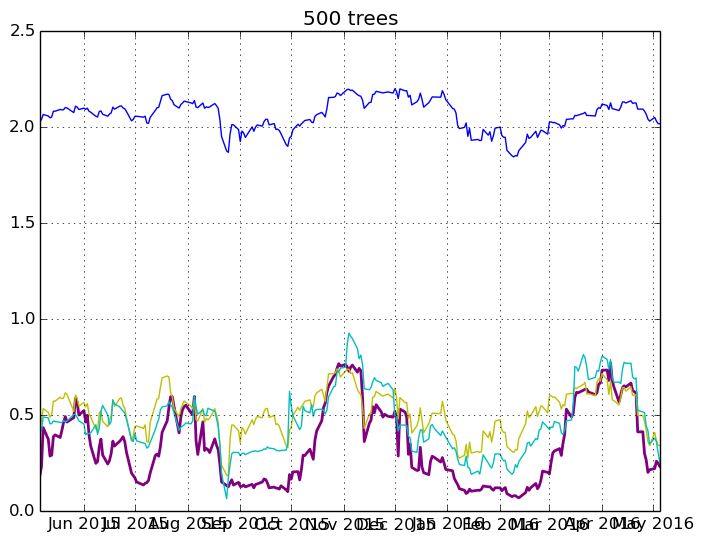

In [3266]:
plot(newfeatures.timestamp,newfeatures.values[:,closeidx]./initvalue,c="b")
plot(newfeatures.timestamp,newlabels,c="Purple",linewidth=2)
plot(newfeatures.timestamp,newfeatures.values[:,11],c="y")
plot(newfeatures.timestamp,newfeatures.values[:,12],c="c")
title(string(ntrees)*" trees")
grid("on")